In [1]:
import glob
import os 

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
sns.set(font_scale=1.4)

In [2]:
import files
import occupancy
import wait_times
import vehicles
import constants

# General Utils

In [16]:
SCENARIOS_PATH = r"E:/Files/CodeProjects/MATSim/Scenarios/"
RUN_DIR = "downscaling-test-line-beta1800-rebalance"
PATH = os.path.join(SCENARIOS_PATH, RUN_DIR)

# Wait time utils

In [17]:
r = files.iterate_algorithms(PATH, wait_times.get_wait_stats)
pd.DataFrame(r).stack().unstack(level=-2)

output for RUN_ID: downscaling-test-line-beta1800-rebalance, from func: get_wait_stats


,mean wait,95p wait,rejection rate,avg travel time,avg direct distance,avg trip distance
DRT-k0.01,537.61,1653.45,0.00,2309.52,4915.74,6144.98
DRT-k0.05,800.97,1751.65,0.00,2603.59,4610.67,5724.06
DRT-k0.25,930.68,1766.00,0.00,2836.31,4830.46,6071.84
DRT-k0.5,1007.98,1764.45,0.00,2928.64,4897.08,6169.93
DRT-k1.0,1075.60,1759.00,0.23,3182.21,5461.74,7011.78


# Fleet distance

In [18]:
r = files.iterate_algorithms(PATH, vehicles.get_distances_stats)
pd.DataFrame(r).stack().unstack(level=-2) / 1000

output for RUN_ID: downscaling-test-line-beta1800-rebalance, from func: get_distances_stats


,total distance,total empty distance,empty ratio
DRT-k0.01,416.06146,0.97733,0.00000
DRT-k0.05,1300.44641,9.03312,0.00001
DRT-k0.25,5117.24515,65.07497,0.00001
DRT-k0.5,9423.03473,337.36475,0.00004
DRT-k1.0,13005.66103,259.08630,0.00002


# Ocuupancy utils

In [27]:
df2 = files.iterate_algorithms(PATH, occupancy.get_ocucpancy_aggregation)
df = pd.DataFrame(df2).stack().unstack(level=-2).fillna(0)
df.style.format({col: '{:,.2f}'
                 for col in df.columns if "avg" not in col})

output for RUN_ID: downscaling-test-line-beta1800-rebalance, from func: get_ocucpancy_aggregation


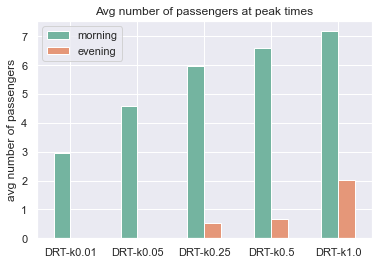

In [20]:
ax = df["avg number of passengers"].unstack(level=0)\
    .plot.bar(rot=0, 
              title="Avg number of passengers at peak times", 
              color=sns.color_palette("Set2", desat=0.7))
ax.set_ylabel("avg number of passengers")
ticks_labels = [constants.LONG_TO_SHORT_NAME.get(tick.get_text(), tick)
                for tick 
                in ax.get_xticklabels()]
ax.set_xticklabels(ticks_labels)
ax

output for RUN_ID: downscaling-test-line-beta1800-rebalance, from func: get_occupancy_per_hour


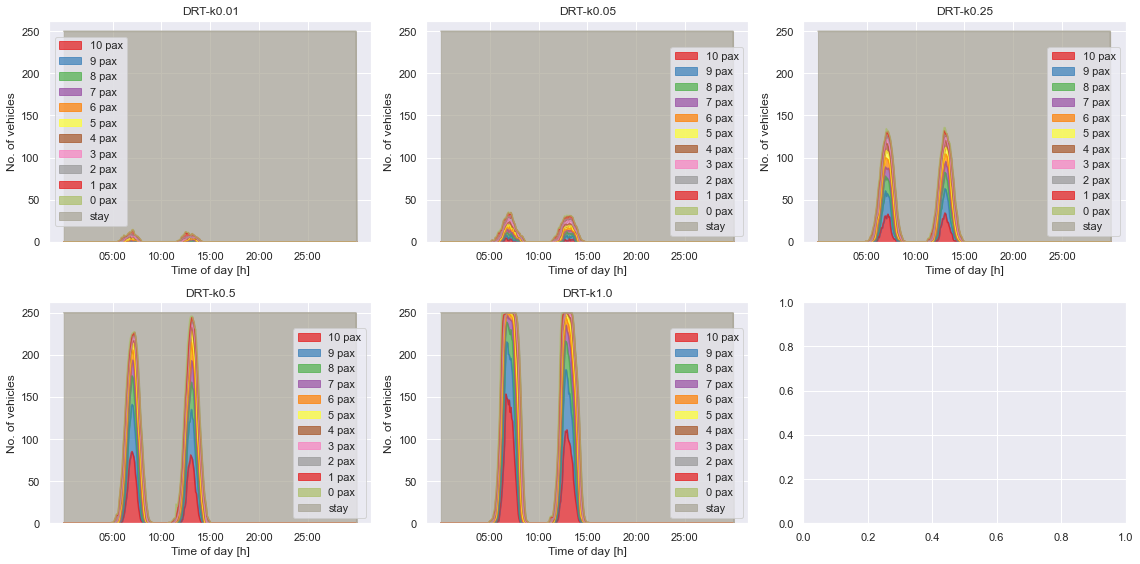

In [21]:
occupancy_dfs = files.iterate_algorithms(PATH, occupancy.get_occupancy_per_hour)
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(16,8))
for i, alg in enumerate(occupancy_dfs.keys()):
    ax = axes[i//3][i%3]
    occupancy.plot_occuancy_data(occupancy_dfs[alg], alg, ax)
fig.tight_layout()